<a href="https://colab.research.google.com/github/adrianestebanrodriguez/Repositorio_Datasets/blob/main/estudio_del_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nombre del Proyecto: Identificación de cáncer con mayor incidencia en el departamento de Antioquia

**Datos obtenidos de:** Instituto nacional de cancerología

##Objetivo del análisis:
Identificar el tipo de cáncer con mayor crecimiento en el departamento de Antioquia a partir de un dataset de información desde el año 1997 a 2022

##Alcance:
Realizar una proyección lineal simple a partir del crecimiento promedio de casos del cámcer con mayor incidencia en Antioquia para el año 2026

In [52]:
import pandas as pd
import numpy as np
import re # Para expresiones regulares en la limpieza de texto

# 1. Cargar el dataset
try:
    # Asume que el archivo Excel está en la misma carpeta o ruta accesible
    df = pd.read_excel('dataset cancer.xlsx')
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'dataset cancer.xlsx' esté en la ruta correcta.")
    # Si estás ejecutando esto en un entorno donde el archivo está cargado, elimina este bloque 'else'
    # y simplemente usa df = pd.read_excel('dataset cancer.xlsx')
    # No se crea un DataFrame de ejemplo aquí, ya que el error indica que el archivo no se encontró.


# Identificar las columnas de años (series de tiempo)
columnas_años = [col for col in df.columns if str(col).isdigit() and 1997 <= int(col) <= 2023]

## 1. Tratamiento de Valores Faltantes (Guiones)
print("Paso 1: Reemplazando guiones ('-') y guiones con espacios (' - ') con 0 en las columnas de años...")
df[columnas_años] = df[columnas_años].replace(['-', ' - '], '0')

## 2. Normalización y Limpieza de Columnas Categóricas

# 2a. Limpiar la columna 'Tipo de cancer' extrayendo solo el tipo de cáncer.
# Se usa regex para remover el patrón del lugar al final de la cadena, asumiendo que el lugar
# siempre va al final y está separado por un espacio.

def limpiar_tipo_cancer(texto):
    # Patrón para eliminar 'Bogotá D.C', 'Bogota D.C', 'Antioquia', etc., al final de la cadena
    return re.sub(r'\s+(Bogot[áa]\s+D\.?C?\.?|Antioquia|Bogota)\s*$', '', texto).strip()

df['Tipo_Cancer_Limpio'] = df['Tipo de cancer'].apply(limpiar_tipo_cancer)

# 2b. Limpiar y estandarizar la columna 'Lugar'
print("Paso 2: Estandarizando nombres en las columnas 'Lugar' y 'Tipo de cancer'...")
df['Lugar'] = df['Lugar'].str.replace('Bogota', 'Bogotá D.C', case=False, regex=False).str.strip()


## 3. Conversión de Tipo de Datos
print("Paso 3: Convirtiendo columnas de años a tipo entero (Integer)...")
# Forzar la conversión de las columnas de años a tipo numérico entero
df[columnas_años] = df[columnas_años].astype(int)


# Eliminar la columna original 'Tipo de cancer' que ahora está duplicada y sucia
df = df.drop(columns=['Tipo de cancer'])
df = df.rename(columns={'Tipo_Cancer_Limpio': 'Tipo de cancer'})

## 4. Estructuración para Análisis (Formato Largo)
print("Paso 4: Transformando el dataset de formato Ancho a formato Largo ('Long Format')...")
df_long = df.melt(
    id_vars=['Tipo de cancer', 'Lugar', 'Sexo'],
    value_vars=columnas_años,
    var_name='Año',
    value_name='Casos_Incidencia'
)

# Asegurar que la columna 'Año' sea de tipo entero después de la transformación
df_long['Año'] = df_long['Año'].astype(int)

# 5. Ordenar el dataset final por ubicación, tipo de cáncer y año
df_long = df_long.sort_values(by=['Lugar', 'Tipo de cancer', 'Sexo', 'Año']).reset_index(drop=True)

# Mostrar las primeras filas del dataset limpio y transformado
print("\n--- Vista Previa del Dataset Limpio y Transformado (Formato Largo) ---")
print(df_long.head(10).to_markdown(index=False))

print("\nLimpieza y transformación completada. El dataset está listo para el análisis.")
print(f"Columnas finales: {list(df_long.columns)}")

Paso 1: Reemplazando guiones ('-') y guiones con espacios (' - ') con 0 en las columnas de años...
Paso 2: Estandarizando nombres en las columnas 'Lugar' y 'Tipo de cancer'...
Paso 3: Convirtiendo columnas de años a tipo entero (Integer)...
Paso 4: Transformando el dataset de formato Ancho a formato Largo ('Long Format')...

--- Vista Previa del Dataset Limpio y Transformado (Formato Largo) ---
| Tipo de cancer   | Lugar     | Sexo   |   Año |   Casos_Incidencia |
|:-----------------|:----------|:-------|------:|-------------------:|
| Colon            | Antioquia | Hombre |  1997 |                 98 |
| Colon            | Antioquia | Hombre |  1998 |                 88 |
| Colon            | Antioquia | Hombre |  1999 |                 76 |
| Colon            | Antioquia | Hombre |  2000 |                 85 |
| Colon            | Antioquia | Hombre |  2001 |                102 |
| Colon            | Antioquia | Hombre |  2002 |                 93 |
| Colon            | Antioquia | H

In [53]:
## Medidas de tendencia central
print(df_long.describe())

               Año  Casos_Incidencia
count   864.000000        864.000000
mean   2010.000000        100.275463
std       7.793392        126.863886
min    1997.000000          0.000000
25%    2003.000000         11.000000
50%    2010.000000         31.500000
75%    2017.000000        164.250000
max    2023.000000        591.000000


In [54]:
# Filtrar los datos para los años cada 5 años
años_seleccionados = range(df_long['Año'].min(), df_long['Año'].max() + 1, 5)
df_cada_cinco_años = df_long[df_long['Año'].isin(años_seleccionados)].copy()

# Agrupar por Tipo de cancer y Año y sumar Casos_Incidencia
incidencia_cada_cinco_años = df_cada_cinco_años.groupby(['Tipo de cancer', 'Año'])['Casos_Incidencia'].sum().reset_index()

# Mostrar el resultado
print("\n--- Total de Casos de Incidencia por Tipo de Cáncer Cada Cinco Años ---")
print(incidencia_cada_cinco_años.to_markdown(index=False))


--- Total de Casos de Incidencia por Tipo de Cáncer Cada Cinco Años ---
| Tipo de cancer    |   Año |   Casos_Incidencia |
|:------------------|------:|-------------------:|
| Colon             |  1997 |                384 |
| Colon             |  2002 |                472 |
| Colon             |  2007 |                640 |
| Colon             |  2012 |                812 |
| Colon             |  2017 |               1043 |
| Colon             |  2022 |               1151 |
| Estómago          |  1997 |               1110 |
| Estómago          |  2002 |               1294 |
| Estómago          |  2007 |               1414 |
| Estómago          |  2012 |               1453 |
| Estómago          |  2017 |               1666 |
| Estómago          |  2022 |               1689 |
| Hueso             |  1997 |                 76 |
| Hueso             |  2002 |                 77 |
| Hueso             |  2007 |                 71 |
| Hueso             |  2012 |                 96 |
| Hueso  

In [57]:
# Calcular la media de casos de incidencia por tipo de cáncer en el DataFrame quinquenal
promedio_incidencia_quinquenal = incidencia_cada_cinco_años.groupby('Tipo de cancer')['Casos_Incidencia'].mean().reset_index()

# Ordenar los resultados por la media de casos de forma descendente
promedio_incidencia_quinquenal = promedio_incidencia_quinquenal.sort_values(by='Casos_Incidencia', ascending=False)

# Mostrar el resultado
print("\n--- Promedio de Casos de Incidencia por Tipo de Cáncer (Cada Cinco Años) ---")
print(promedio_incidencia_quinquenal.to_markdown(index=False))


--- Promedio de Casos de Incidencia por Tipo de Cáncer (Cada Cinco Años) ---
| Tipo de cancer    |   Casos_Incidencia |
|:------------------|-------------------:|
| Estómago          |          1437.67   |
| Colon             |           750.333  |
| Hígado            |           556      |
| Riñón             |           165.833  |
| Tiroides          |           100.667  |
| Hueso             |            84.6667 |
| Intestino delgado |            31.1667 |
| Ojo               |            10      |


In [58]:
# Agrupar por Lugar y Tipo de cancer y sumar los Casos_Incidencia
incidencia_por_lugar_tipo = df_long.groupby(['Lugar', 'Tipo de cancer'])['Casos_Incidencia'].sum().reset_index()

# Encontrar el tipo de cáncer más común por lugar (el que tiene el mayor total de casos)
# Para cada lugar, ordenar por Casos_Incidencia descendente y tomar el primero
tipos_cancer_mas_comunes_por_lugar = incidencia_por_lugar_tipo.loc[incidencia_por_lugar_tipo.groupby('Lugar')['Casos_Incidencia'].idxmax()].reset_index(drop=True)

# Mostrar el resultado
print("\n--- Tipo de Cáncer Más Común por Lugar (Basado en el Total de Casos de Incidencia) ---")
print(tipos_cancer_mas_comunes_por_lugar.to_markdown(index=False))

print("\nNota: Este resultado muestra el tipo de cáncer con el mayor número total de casos de incidencia acumulados en todo el período para cada lugar.")


--- Tipo de Cáncer Más Común por Lugar (Basado en el Total de Casos de Incidencia) ---
| Lugar      | Tipo de cancer   |   Casos_Incidencia |
|:-----------|:-----------------|-------------------:|
| Antioquia  | Estómago         |              17216 |
| Bogotá D.C | Estómago         |              21764 |

Nota: Este resultado muestra el tipo de cáncer con el mayor número total de casos de incidencia acumulados en todo el período para cada lugar.


# Tarea
Analizar el tipo de cáncer con mayor crecimiento interanual de casos en Antioquia utilizando el DataFrame `df_long`.

## Filtrar datos por lugar

### Acción realizada:
Se hace un Filtrado del DataFrame `df_long` para incluir solo los datos correspondientes a "Antioquia".


In [61]:
##Se hacce un filtrado de las incidencias de cáncer por año sólo en Antioquia
df_antioquia = df_long[df_long['Lugar'] == 'Antioquia'].copy()
print("DataFrame filtrado para Antioquia:")
print(df_antioquia.head().to_markdown(index=False))

DataFrame filtrado para Antioquia:
| Tipo de cancer   | Lugar     | Sexo   |   Año |   Casos_Incidencia |
|:-----------------|:----------|:-------|------:|-------------------:|
| Colon            | Antioquia | Hombre |  1997 |                 98 |
| Colon            | Antioquia | Hombre |  1998 |                 88 |
| Colon            | Antioquia | Hombre |  1999 |                 76 |
| Colon            | Antioquia | Hombre |  2000 |                 85 |
| Colon            | Antioquia | Hombre |  2001 |                102 |


## Calcular cambio anual

### Acción realizada:
Para cada tipo de cáncer en Antioquia, calcular la diferencia en los casos de incidencia entre años consecutivos.


In [63]:
##Ordene el DataFrame filtrado por 'Tipo de cáncer', 'Sexo' y 'Año' y luego calcule la diferencia interanual en 'Casos_Incidencia' para cada grupo.
df_antioquia = df_antioquia.sort_values(by=['Tipo de cancer', 'Sexo', 'Año'])
df_antioquia['Cambio_Anual'] = df_antioquia.groupby(['Tipo de cancer', 'Sexo'])['Casos_Incidencia'].diff()
print(df_antioquia.head().to_markdown(index=False))

| Tipo de cancer   | Lugar     | Sexo   |   Año |   Casos_Incidencia |   Cambio_Anual |
|:-----------------|:----------|:-------|------:|-------------------:|---------------:|
| Colon            | Antioquia | Hombre |  1997 |                 98 |            nan |
| Colon            | Antioquia | Hombre |  1998 |                 88 |            -10 |
| Colon            | Antioquia | Hombre |  1999 |                 76 |            -12 |
| Colon            | Antioquia | Hombre |  2000 |                 85 |              9 |
| Colon            | Antioquia | Hombre |  2001 |                102 |             17 |


## Calcular crecimiento promedio

### Acción realizada:
Calcular el crecimiento promedio anual para cada tipo de cáncer en Antioquia.


In [71]:
##Calcula el cambio anual absoluto y luego agrupa por 'Tipo de cáncer' para encontrar el cambio absoluto promedio, almacenando el resultado en un nuevo DataFrame.
df_antioquia['Cambio_Anual_Abs'] = df_antioquia['Cambio_Anual'].abs()
crecimiento_promedio_antioquia = df_antioquia.groupby('Tipo de cancer')['Cambio_Anual_Abs'].mean().reset_index()
print("\n--- Crecimiento Promedio Anual por Tipo de Cáncer en Antioquia (Valor Absoluto) ---")
print(crecimiento_promedio_antioquia.head().to_markdown(index=False))


--- Crecimiento Promedio Anual por Tipo de Cáncer en Antioquia (Valor Absoluto) ---
| Tipo de cancer    |   Cambio_Anual_Abs |
|:------------------|-------------------:|
| Colon             |           18.5     |
| Estómago          |           21.4423  |
| Hueso             |            4.86538 |
| Hígado            |           17.2115  |
| Intestino delgado |            3.30769 |


## Identificar cáncer de mayor crecimiento

### Acción realizada:
Identificar el tipo de cáncer con el mayor crecimiento promedio anual.


In [68]:
##Para identificar el tipo de cáncer con el mayor crecimiento promedio anual, ordeno el DataFrame `crecimiento promedio antioquia` por 'Cambio_Anual_Abs' en orden descendente y selecciono la fila superior.
cancer_mayor_crecimiento = crecimiento_promedio_antioquia.sort_values(by='Cambio_Anual_Abs', ascending=False).iloc[0]
print("\n--- Tipo de Cáncer con el Mayor Crecimiento Promedio Anual en Antioquia ---")
print(cancer_mayor_crecimiento.to_markdown())


--- Tipo de Cáncer con el Mayor Crecimiento Promedio Anual en Antioquia ---
|                  | 1                  |
|:-----------------|:-------------------|
| Tipo de cancer   | Estómago           |
| Cambio_Anual_Abs | 21.442307692307693 |


In [74]:
# Identificar el tipo de cáncer de mayor crecimiento y su crecimiento promedio anual
tipo_cancer_mayor_crecimiento = cancer_mayor_crecimiento['Tipo de cancer']
crecimiento_promedio = cancer_mayor_crecimiento['Cambio_Anual_Abs']

# Filtrar el DataFrame para obtener solo los datos del tipo de cáncer de mayor crecimiento en Antioquia
df_antioquia_mayor_crecimiento = df_antioquia[df_antioquia['Tipo de cancer'] == tipo_cancer_mayor_crecimiento].copy()

# Obtener el número de casos en el último año disponible para ese tipo de cáncer en Antioquia
ultimo_año_datos = df_antioquia_mayor_crecimiento['Año'].max()
casos_ultimo_año = df_antioquia_mayor_crecimiento[df_antioquia_mayor_crecimiento['Año'] == ultimo_año_datos]['Casos_Incidencia'].sum()


# Proyectar los casos para el año 2026 (asumiendo un crecimiento lineal basado en el promedio)
años_a_proyectar = 2026 - ultimo_año_datos
proyeccion_2026 = casos_ultimo_año + (crecimiento_promedio * años_a_proyectar)

print(f"\n--- Proyección de Casos de {tipo_cancer_mayor_crecimiento} en Antioquia para 2026 ---")
print(f"Basado en los datos hasta {ultimo_año_datos} y un crecimiento promedio anual de {crecimiento_promedio:.2f} casos:")
print(f"Proyección de casos para 2026: aproximadamente {proyeccion_2026:.0f}")

print("\nNota: Esta es una proyección simple y lineal que asume que las tendencias pasadas continuarán. Factores externos pueden influir en los resultados reales.")


--- Proyección de Casos de Estómago en Antioquia para 2026 ---
Basado en los datos hasta 2023 y un crecimiento promedio anual de 21.44 casos:
Proyección de casos para 2026: aproximadamente 764

Nota: Esta es una proyección simple y lineal que asume que las tendencias pasadas continuarán. Factores externos pueden influir en los resultados reales.


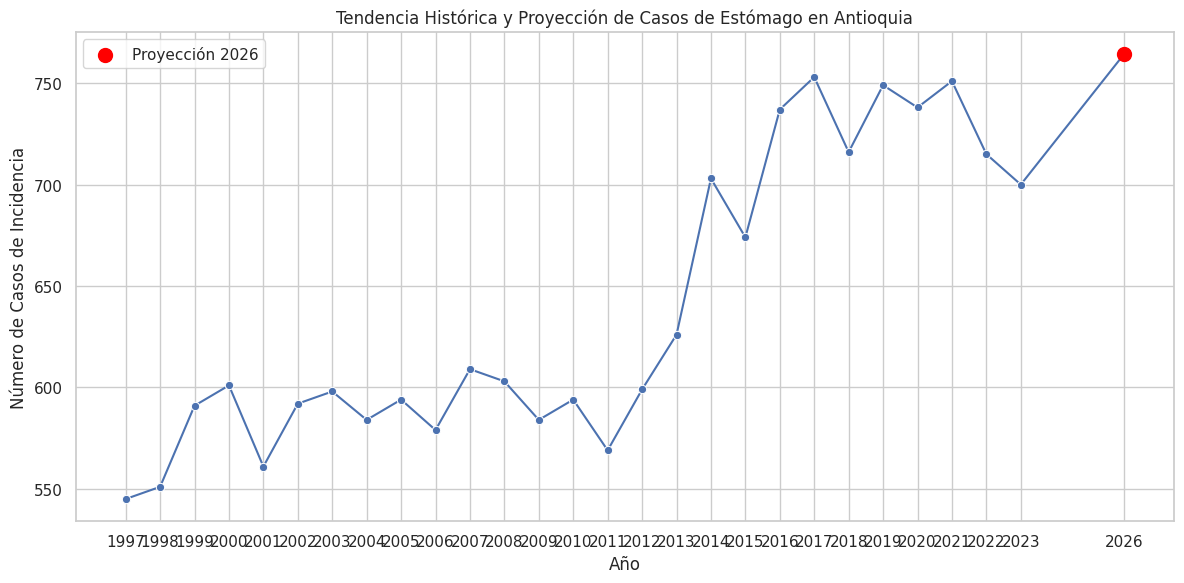

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurarse de tener los datos históricos para el tipo de cáncer de mayor crecimiento en Antioquia
# (Este DataFrame ya debería existir de pasos anteriores)
# df_antioquia_mayor_crecimiento

# Crear un DataFrame para la proyección
df_proyeccion = pd.DataFrame({
    'Tipo de cancer': [tipo_cancer_mayor_crecimiento],
    'Lugar': ['Antioquia'],
    'Sexo': ['Ambos Sexos'], # Asumimos ambos sexos para la proyección total
    'Año': [2026],
    'Casos_Incidencia': [proyeccion_2026]
})

# Sumar los casos históricos por año y tipo de cancer en Antioquia (agregando ambos sexos para la visualización)
df_antioquia_mayor_crecimiento_anual = df_antioquia_mayor_crecimiento.groupby(['Tipo de cancer', 'Año'])['Casos_Incidencia'].sum().reset_index()


# Combinar los datos históricos con la proyección
df_visualizacion = pd.concat([df_antioquia_mayor_crecimiento_anual, df_proyeccion], ignore_index=True)

# Ordenar por año para el gráfico
df_visualizacion = df_visualizacion.sort_values(by='Año')

# Configurar el estilo de Seaborn
sns.set_theme(style="whitegrid")

# Crear el gráfico de línea
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_visualizacion, x='Año', y='Casos_Incidencia', marker='o')

# Resaltar el punto de proyección
plt.scatter(df_proyeccion['Año'], df_proyeccion['Casos_Incidencia'], color='red', s=100, zorder=5, label=f'Proyección {df_proyeccion["Año"].iloc[0]}')

# Añadir etiquetas y título
plt.title(f'Tendencia Histórica y Proyección de Casos de {tipo_cancer_mayor_crecimiento} en Antioquia')
plt.xlabel('Año')
plt.ylabel('Número de Casos de Incidencia')
plt.xticks(df_visualizacion['Año']) # Asegurar que todos los años se muestren en el eje x
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Mostrar resultado

### Acción realizada:
Presentar el tipo de cáncer identificado y su crecimiento promedio anual.


In [70]:
print(f"\n--- Tipo de Cáncer con el Mayor Crecimiento Promedio Anual en Antioquia ---")
print(f"El tipo de cáncer con el mayor crecimiento promedio anual en Antioquia es '{cancer_mayor_crecimiento['Tipo de cancer']}'")
print(f"Su crecimiento promedio anual es de aproximadamente {cancer_mayor_crecimiento['Cambio_Anual_Abs']:.2f} casos.")


--- Tipo de Cáncer con el Mayor Crecimiento Promedio Anual en Antioquia ---
El tipo de cáncer con el mayor crecimiento promedio anual en Antioquia es 'Estómago'
Su crecimiento promedio anual es de aproximadamente 21.44 casos.


#**Resumen**:
##Hallazgos Clave del Análisis de Datos
El análisis se centró en los datos de incidencia de cáncer específicamente para Antioquia.

*Se calculó la variación interanual de los casos de incidencia para cada tipo de cáncer y sexo.

*Se calculó el crecimiento anual absoluto promedio para cada tipo de cáncer en ambos sexos.

**El tipo de cáncer con el mayor crecimiento anual promedio en Antioquia es el de estómago, con un aumento promedio de aproximadamente 21,44 casos por año.

##Perspectivas o Próximos Pasos

**Investigaciones adicionales podrían explorar las posibles razones detrás del significativo crecimiento anual promedio de los casos de cáncer de estómago en Antioquia, considerando factores como el estilo de vida, las influencias ambientales o los cambios en las tasas de detección.
Sería beneficioso analizar la tendencia de los casos de cáncer de estómago durante un período más largo o comparar la tasa de crecimiento en Antioquia con la de otras regiones para comprender si se trata de un fenómeno localizado o más amplio.
